In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import scipy
import matplotlib.pyplot as plt

In [2]:
from GHKF import GHKF
from EKF import EKF

Imported GHKF
Imported EKF


In [3]:
import sympy
from IPython.display import display

In [4]:
from time import perf_counter

In [5]:
def trueMeanAndCov(m, cov, f, u, f_return_dim, x_dim, dt, for_measurement=False, f_kwargs=None):
    n = 100
    samples = multivariate_normal.rvs(m.flatten(), cov, n)
    transformed_samples = np.array([]).reshape(0, f_return_dim)
    if f_kwargs is None:
        f_kwargs = {}
    for s in samples:
        sample = s.reshape(x_dim, 1)
        if for_measurement: # measurement model does not take u
            transformed = f(sample, **f_kwargs).reshape(1, f_return_dim)
        else:
            transformed = f(sample, u, dt, **f_kwargs).reshape(1, f_return_dim)
        transformed_samples = np.vstack((transformed_samples, transformed))
    result_mean = np.mean(transformed_samples, axis=0)
    result_cov = np.cov(transformed_samples.T)
    return result_mean.reshape(f_return_dim, 1), result_cov.reshape(f_return_dim, f_return_dim)

#### Balistic tracking

In [6]:
h, v, b, T, a1, a2, g = sympy.symbols('h, v, b, T, a1, a2, g')
A = sympy.Matrix([-v*T + h, 
                  -a1 * sympy.exp(-a2*h) * g * v**2 * T / (2 * b) + T * g + v, 
                  b])
state = sympy.Matrix([h, v, b])
J = A.jacobian(state)
display(state)
display(A)
display(J)

Matrix([
[h],
[v],
[b]])

Matrix([
[                               -T*v + h],
[-T*a1*g*v**2*exp(-a2*h)/(2*b) + T*g + v],
[                                      b]])

Matrix([
[                              1,                         -T,                               0],
[T*a1*a2*g*v**2*exp(-a2*h)/(2*b), -T*a1*g*v*exp(-a2*h)/b + 1, T*a1*g*v**2*exp(-a2*h)/(2*b**2)],
[                              0,                          0,                               1]])

In [7]:
H = sympy.Matrix([h])
state = sympy.Matrix([h, v, b])
J = H.jacobian(state)
display(state)
display(H)
display(J)

Matrix([
[h],
[v],
[b]])

Matrix([[h]])

Matrix([[1, 0, 0]])

In [35]:
q3 = 5
q4 = 5
dt = 0.1
Q = np.array([[q3 * dt**3 / 3, q3 * dt**2 / 2, 0],
              [q3 * dt**2 / 2, q3 * dt, 0],
              [0, 0, q4 * dt]])
# q4_filt = 5000
# Q_filt = np.array([[q3 * dt**3 / 3, q3 * dt**2 / 2, 0],
#               [q3 * dt**2 / 2, q3 * dt, 0],
#               [0, 0, q4_filt * dt]])
Q_filt = Q
Rk = 200
R = Rk**2 * np.eye(1)
m = np.array([60960, 3048, 19161]).reshape(3, 1)
# m_filt = np.array([60960, 3048, 40000]).reshape(3, 1)
m_filt = m
# P = np.diag([1, 1, 1])
sigma_beta = 100_000
P = np.array([[Rk, Rk/dt, 0],
              [Rk/dt, 2*Rk/dt**2, 0],
              [0, 0, sigma_beta]])
nsteps = 300
p = 3
kwargs = { 'a1': 1.754, 'a2': 1.49e-4, 'g': 9.81 }
def f(x, u, dt, **kwargs):
    h = x[0, 0]
    v = x[1, 0]
    b = x[2, 0]
    a1 = kwargs['a1']
    a2 = kwargs['a2']
    g = kwargs['g']
#     x1_next = -dt * v + h
#     x2_next = -a1 * np.exp(-a2*h) * g * v**2 * dt / (2 * b) + dt * g + v
#     x3_next = b
    x1_next = -dt * v + h
    x2_next = -a1 * np.exp(-a2*h) * g * v**2 * dt / (2 * b) + dt * g + v
    x3_next = b
    return np.array([x1_next, x2_next, x3_next]).reshape(3, 1)
# def f_sim(x, u, dt, **kwargs):
#     h = x[0, 0]
#     v = x[1, 0]
#     b = x[2, 0]
#     a1 = kwargs['a1']
#     a2 = kwargs['a2']
#     g = kwargs['g']
#     x1_next = -dt * v + h
#     x2_next = -a1 * np.exp(-a2*h) * g * v**2 * dt / (2 * b) + dt * g + v
#     x3_next = b
#     return np.array([x1_next, x2_next, x3_next]).reshape(3, 1)
# def h(x, **kwargs):
#     M = kwargs['M']
#     a = kwargs['a']
#     h = x[0, 0]
#     return np.array([np.sqrt(M**2 + (h - a)**2)]).reshape(1, 1)
def h(x, **kwargs):
    h = x[0, 0]
    return np.array([h]).reshape(1, 1)

In [36]:
def F(x, u, dt, **kwargs):
    a1 = kwargs['a1']
    a2 = kwargs['a2']
    g = kwargs['g']
    h = x[0, 0]
    v = x[1, 0]
    b = x[2, 0]
    return np.array([[1, -dt, 0], 
                     [dt * a1 * a2 * g * v**2 * np.exp(-h*a2) / (2*b), -dt*a1*g*v*np.exp(-a2*h)/b + 1, dt*a1*g*v**2*np.exp(-a2*h)/(2*b**2)],
                     [0, 0, 1]])
# def H(x, **kwargs):
#     M = kwargs['M']
#     a = kwargs['a']
#     h = x[0, 0]
#     return np.array([(-a + h)/np.sqrt(M**2 + (-a + h)**2), 0, 0]).reshape(1, 3)
def H(x, **kwargs):
    h = x[0, 0]
    return np.array([1, 0, 0]).reshape(1, 3)

# def F(x, u, dt, **kwargs):
#     a1 = kwargs['a1']
#     a2 = kwargs['a2']
#     g = kwargs['g']
#     h = x[0, 0]
#     v = x[1, 0]
#     b = x[2, 0]
#     return np.array([[1, -dt, 0], 
#                      [0, 1, 0],
#                      [0, 0, 1]])

Process model function for velocity ($x_2$):

In [37]:
def next_v(v, h, dt, b):
    a1 = kwargs['a1']
    a2 = kwargs['a2']
    g = kwargs['g']
    v_next = -a1 * np.exp(-a2*h) * g * v**2 * dt / (2 * b) + dt * g + v
    return v_next

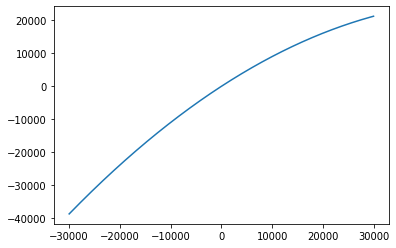

In [38]:
height = 10_000
b = 20_000
vs = np.linspace(-30000, 30000, 1000)
plt.plot(vs, next_v(vs, height, dt, b))
plt.show()

In [39]:
ekf = EKF.ExtendedKalmanFilter(m_filt, P, Q_filt, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m_filt, P, Q_filt, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)

In [40]:
np.random.seed(2022)
x = m
# x = np.array([60960, 3048, 19161]).reshape(3, 1)
x_noisy = x + multivariate_normal.rvs([0, 0, 0], Q).reshape(3, 1)
xs = []
xs_ekf = []
xs_ghkf = []
ts = []
for k in range(nsteps): 
    u = 0
#     x = f(x, u, dt, **kwargs)
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=3, x_dim=3, dt=dt,
                          f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs([0, 0, 0], Q).reshape(3, 1)
    xs.append(x_noisy)
    # measurement
    ekf.predict(u)
    ghkf.predict(u)
#     z = h(x_noisy, **kwargs)
    z, Pz = trueMeanAndCov(x_noisy, ghkf.P, f=h, u=u, f_return_dim=1, x_dim=3, 
                       dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs_ekf.append(ekf.m)
    xs_ghkf.append(ghkf.m)
    ts.append(k*dt)

In [41]:
true_h = np.array(list(map(lambda x: x[0, 0], xs)))
true_v = np.array(list(map(lambda x: x[1, 0], xs)))
true_b = np.array(list(map(lambda x: x[2, 0], xs)))
h_ekf = np.array(list(map(lambda x: x[0, 0], xs_ekf)))
v_ekf = np.array(list(map(lambda x: x[1, 0], xs_ekf)))
b_ekf = np.array(list(map(lambda x: x[2, 0], xs_ekf)))
h_ghkf = np.array(list(map(lambda x: x[0, 0], xs_ghkf)))
v_ghkf = np.array(list(map(lambda x: x[1, 0], xs_ghkf)))
b_ghkf = np.array(list(map(lambda x: x[2, 0], xs_ghkf)))

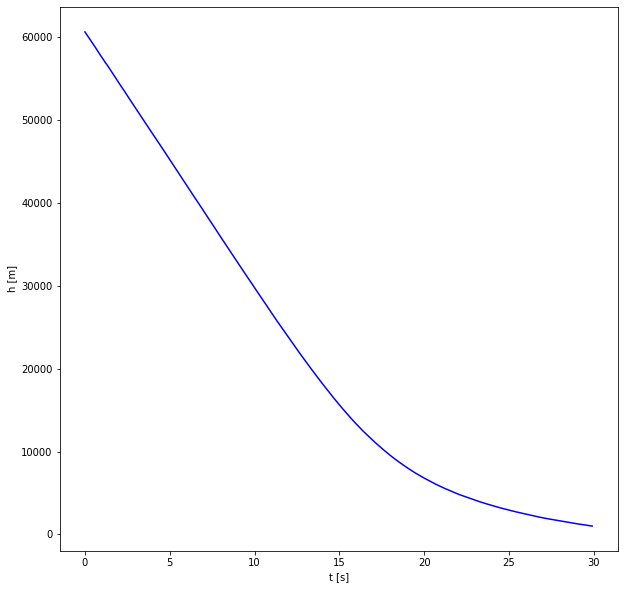

In [27]:
plt.figure(figsize=(10, 10))
plt.plot(ts, true_h, 'b-')
plt.xlabel(r't [s]')
plt.ylabel(r'h [m]')
# plt.savefig('ballistic_tracking_typical_h.jpg', bbox_inches='tight')
plt.show()

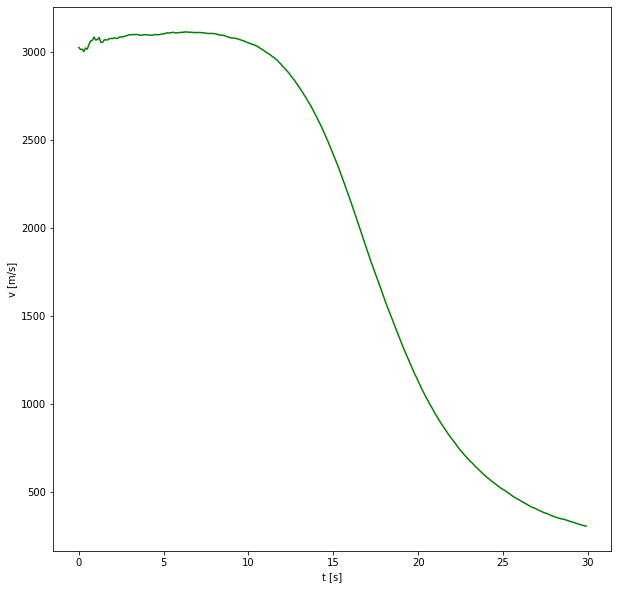

In [28]:
plt.figure(figsize=(10, 10))
plt.plot(ts, true_v, 'g-')
plt.xlabel(r't [s]')
plt.ylabel(r'v [m/s]')
# plt.savefig('ballistic_tracking_typical_v.jpg', bbox_inches='tight')
plt.show()

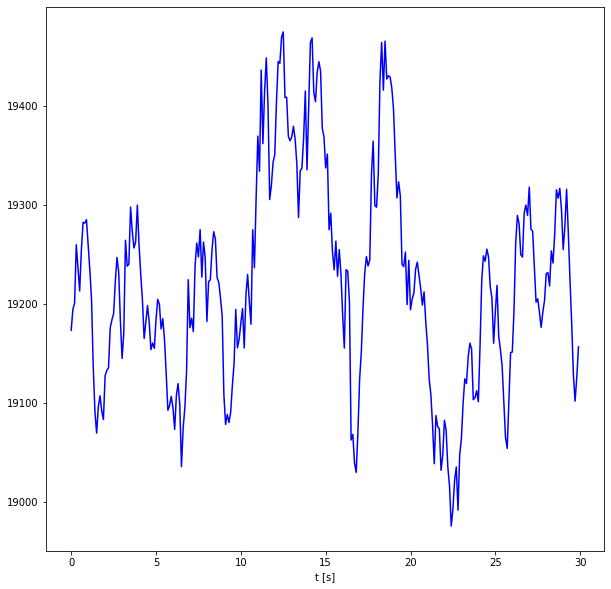

In [29]:
plt.figure(figsize=(10, 10))
plt.plot(ts, true_b, 'b-')
plt.xlabel(r't [s]')
plt.show()

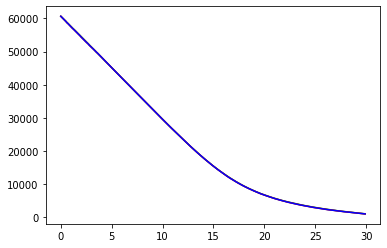

In [42]:
plt.plot(ts, true_h, 'g-')
plt.plot(ts, h_ekf, 'r-')
plt.plot(ts, h_ghkf, 'b-')
plt.show()

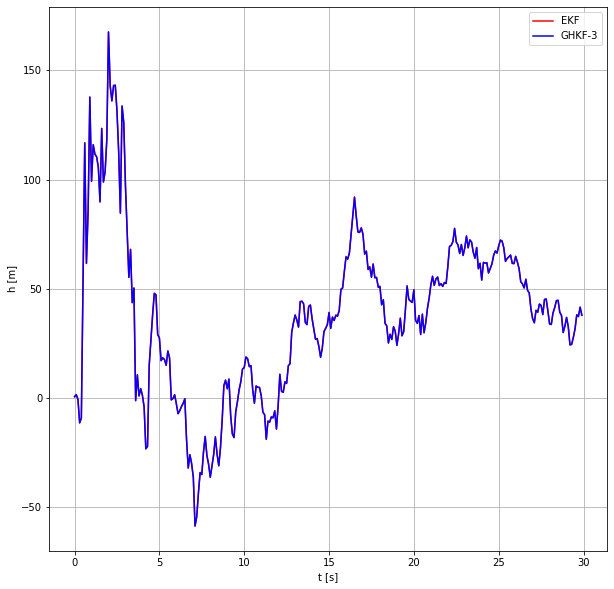

In [49]:
plt.figure(figsize=(10, 10))
plt.plot(ts, true_h-h_ekf, 'r-')
plt.plot(ts, true_h-h_ghkf, 'b-')
plt.legend(['EKF', 'GHKF-3'])
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.grid()
plt.savefig('ballistic_tracking_h_errors.jpg', bbox_inches='tight')
plt.show()

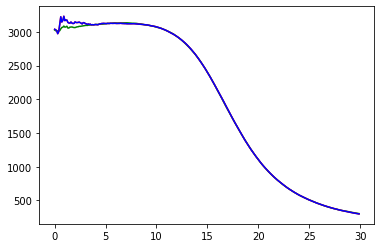

In [44]:
plt.plot(ts, true_v, 'g-')
plt.plot(ts, v_ekf, 'r-')
plt.plot(ts, v_ghkf, 'b-')
plt.show()

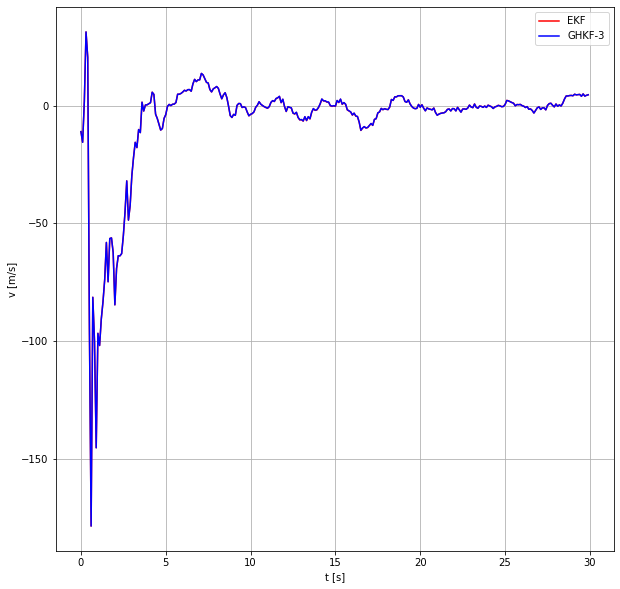

In [50]:
plt.figure(figsize=(10, 10))
plt.plot(ts, true_v-v_ekf, 'r-')
plt.plot(ts, true_v-v_ghkf, 'b-')
plt.legend(['EKF', 'GHKF-3'])
plt.xlabel('t [s]')
plt.ylabel('v [m/s]')
plt.grid()
plt.savefig('ballistic_tracking_v_errors.jpg', bbox_inches='tight')
plt.show()

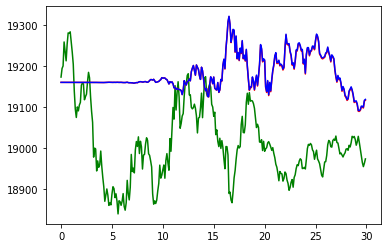

In [46]:
plt.plot(ts, true_b, 'g-')
plt.plot(ts, b_ekf, 'r-')
plt.plot(ts, b_ghkf, 'b-')
plt.show()

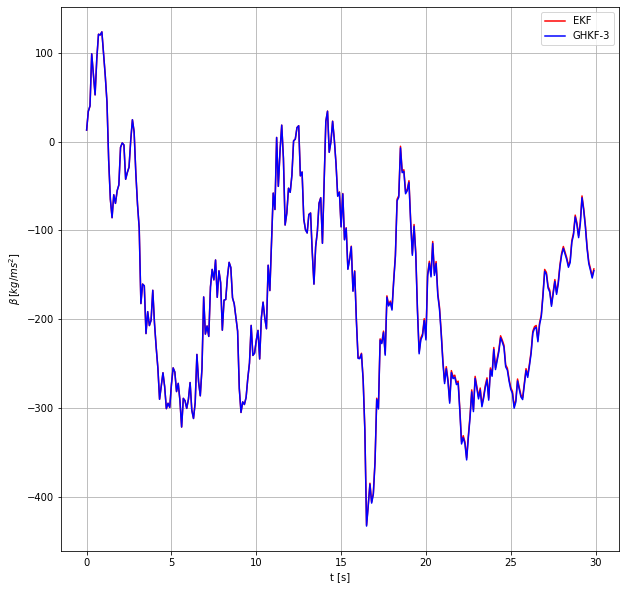

In [53]:
plt.figure(figsize=(10, 10))
plt.plot(ts, true_b - b_ekf, 'r-')
plt.plot(ts, true_b - b_ghkf, 'b-')
plt.legend(['EKF', 'GHKF-3'])
plt.xlabel('t [s]')
plt.ylabel(r'$\beta\,[kg/ms^2]$')
plt.grid()
plt.savefig('ballistic_tracking_b_errors.jpg', bbox_inches='tight')
plt.show()

#### 2-D object movement tracking

In [6]:
x1, vx, ax, y, vy, ay, T = sympy.symbols('x_1, v_x, a_x, y, v_y, a_y, T')
A = sympy.Matrix([x1 + T * vx + 0.5 * T**2 * ax, 
                  vx + T * ax, 
                  ax,
                  y + T * vy + 0.5 * T**2 * ay,
                  vy + T * ay,
                  ay])
state = sympy.Matrix([x1, vx, ax, y, vy, ay])
J = A.jacobian(state)
display(state)
display(A)
display(J)

Matrix([
[x_1],
[v_x],
[a_x],
[  y],
[v_y],
[a_y]])

Matrix([
[0.5*T**2*a_x + T*v_x + x_1],
[               T*a_x + v_x],
[                       a_x],
[  0.5*T**2*a_y + T*v_y + y],
[               T*a_y + v_y],
[                       a_y]])

Matrix([
[1, T, 0.5*T**2, 0, 0,        0],
[0, 1,        T, 0, 0,        0],
[0, 0,        1, 0, 0,        0],
[0, 0,        0, 1, T, 0.5*T**2],
[0, 0,        0, 0, 1,        T],
[0, 0,        0, 0, 0,        1]])

In [7]:
x1, vx, ax, y, vy, ay = sympy.symbols('x_1, v_x, a_x, y, v_y, a_y')
H = sympy.Matrix([sympy.sqrt(x1**2 + y**2), sympy.atan(x1/y), (x1*vx + y*vy)/sympy.sqrt(x1**2 + y**2)])
state = sympy.Matrix([x1, vx, ax, y, vy, ay])
J = H.jacobian(state)
display(state)
display(H)
display(J)

Matrix([
[x_1],
[v_x],
[a_x],
[  y],
[v_y],
[a_y]])

Matrix([
[                  sqrt(x_1**2 + y**2)],
[                          atan(x_1/y)],
[(v_x*x_1 + v_y*y)/sqrt(x_1**2 + y**2)]])

Matrix([
[                                               x_1/sqrt(x_1**2 + y**2),                       0, 0,                                                y/sqrt(x_1**2 + y**2),                     0, 0],
[                                               1/(y*(x_1**2/y**2 + 1)),                       0, 0,                                        -x_1/(y**2*(x_1**2/y**2 + 1)),                     0, 0],
[v_x/sqrt(x_1**2 + y**2) - x_1*(v_x*x_1 + v_y*y)/(x_1**2 + y**2)**(3/2), x_1/sqrt(x_1**2 + y**2), 0, v_y/sqrt(x_1**2 + y**2) - y*(v_x*x_1 + v_y*y)/(x_1**2 + y**2)**(3/2), y/sqrt(x_1**2 + y**2), 0]])

In [8]:
np.random.seed(seed=3)
Q = np.diag([10, 10, 10, 10, 10, 10])
# Q = np.diag([0, 0, 1000, 0, 0, 1000])
Q_filt = np.diag([0, 0, 1000, 0, 0, 1000])
# R = np.diag([10, 0.003, 9])
R = np.diag([10, 0.003])
R_filt = R
P = np.eye(6)
dt = 1
dt_filt = dt
m = np.array([200, 50, 15, 100, 80, 20]).reshape(6, 1)
nsteps = 100
def f_sim(x, u, k, dt=dt):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    x1_next = x1 + dt * vx + 0.5 * dt**2 * ax
    x4_next = y + dt * vy + 0.5 * dt**2 * ay
    x2_next = vx + dt * ax
    x5_next = vy + dt * ay
    if 50 < k:
        x3_next = ax - 5
    else:
        x3_next = ax
#     x3_next = 0.5*ax*(1. + 50. * np.power(1. + ax**2, -1.)) + 8 * np.cos(1.2*(k-1))
#     x6_next = 0.5*ay*(1. + 50. * np.power(1. + ay**2, -1.)) + 8 * np.cos(1.2*(k-1))
    x6_next = ay
    return np.array([x1_next, x2_next, x3_next, x4_next, x5_next, x6_next]).reshape(6, 1)
def f(x, u, dt):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    x1_next = x1 + dt * vx + 0.5 * dt**2 * ax
    x4_next = y + dt * vy + 0.5 * dt**2 * ay
    x2_next = vx + dt * ax
    x5_next = vy + dt * ay
    x3_next = ax
    x6_next = ay
    return np.array([x1_next, x2_next, x3_next, x4_next, x5_next, x6_next]).reshape(6, 1)
# def h(x):
#     x1 = x[0, 0]
#     vx = x[1, 0]
#     ax = x[2, 0]
#     y = x[3, 0]
#     vy = x[4, 0]
#     ay = x[5, 0]
#     return np.array([np.sqrt(x1**2 + y**2), np.arctan(x1/y), (x1*vx + y*vy)/np.sqrt(x1**2 + y**2)]).reshape(3, 1)
def h(x):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    return np.array([np.sqrt(x1**2 + y**2), np.arctan(x1/y)]).reshape(2, 1)

In [9]:
def F(x, u, dt):
    return np.array([[1, dt, 0.5*dt**2, 0, 0, 0],
                     [0, 1, dt, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, dt, 0.5*dt**2],
                     [0, 0, 0, 0, 1, dt],
                     [0, 0, 0, 0, 0, 1]])
# def H(x):
#     x1 = x[0, 0]
#     vx = x[1, 0]
#     ax = x[2, 0]
#     y = x[3, 0]
#     vy = x[4, 0]
#     ay = x[5, 0]
#     return np.array([[x1/np.sqrt(x1**2 + y**2), 0, 0, y/np.sqrt(x1**2+y**2), 0, 0],
#                      [1/(y*(x1**2/y**2+1)), 0, 0, -x1/(y**2 * (x1**2/y**2+1)), 0, 0],
#                      [vx/np.sqrt(x1**2+y**2) - (x1*(vx*x1+vy*y))/(x1**2+y**2)**1.5, x1/np.sqrt(x1**2+y**2), 0, vy/np.sqrt(x1**2+y**2) - (y*(vx*x1+vy*y))/(x1**2+y**2)**1.5, y/np.sqrt(x1**2+y**2), 0]])

def H(x):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    return np.array([[x1/np.sqrt(x1**2 + y**2), 0, 0, y/np.sqrt(x1**2+y**2), 0, 0],
                     [1/(y*(x1**2/y**2+1)), 0, 0, -x1/(y**2 * (x1**2/y**2+1)), 0, 0]])

In [10]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, F=F, H=H, dt=dt_filt)
ghkf2 = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=2, dt=dt_filt)
ghkf3 = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=3, dt=dt_filt)
ghkf5 = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=5, dt=dt_filt)

In [11]:
x = m
x_noisy = x
xs = []
xs_noisy = []
xs_filt = []
xs_ekf = []
zs = []
zs_noisy = []
xs_ekf = []
xs_ghkf2 = []
xs_ghkf3 = []
xs_ghkf5 = []
ts = []
for k in range(nsteps):
    x = f_sim(x, u=0, k=k, dt=dt)
    u = 0
    xs.append(x)
    x_noisy = x + multivariate_normal.rvs([0, 0, 0, 0, 0, 0], Q).reshape(6, 1)
    xs_noisy.append(x_noisy)
    ekf.predict(u)
    ghkf2.predict(u)
    ghkf3.predict(u)
    ghkf5.predict(u)
    # measurement
    z, Pz = trueMeanAndCov(x_noisy, ghkf3.P, f=h, u=u, f_return_dim=2, x_dim=6, dt=dt, for_measurement=True)
#         z = h(x) 
    z_noisy = z + multivariate_normal.rvs([0, 0], R).reshape(2, 1)
    ekf.update(z_noisy)
    ghkf2.update(z_noisy)
    ghkf3.update(z_noisy)
    ghkf5.update(z_noisy)
    xs_ekf.append(ekf.m)
    xs_ghkf2.append(ghkf2.m)
    xs_ghkf3.append(ghkf3.m)
    xs_ghkf5.append(ghkf5.m)
    zs.append(z)
    zs_noisy.append(z_noisy)
    xs_filt.append(x)
    ts.append(k*dt)

In [24]:
pos_x = np.array(list(map(lambda x: x[0, 0], xs_noisy)))
pos_y = np.array(list(map(lambda x: x[3, 0], xs_noisy)))
vx = np.array(list(map(lambda x: x[1, 0], xs_noisy)))
vy = np.array(list(map(lambda x: x[4, 0], xs_noisy)))
ax = np.array(list(map(lambda x: x[2, 0], xs_noisy)))
ay = np.array(list(map(lambda x: x[5, 0], xs_noisy)))
ekf_x = np.array(list(map(lambda x: x[0, 0], xs_ekf)))
ekf_y = np.array(list(map(lambda x: x[3, 0], xs_ekf)))
ekf_vx = np.array(list(map(lambda x: x[1, 0], xs_ekf)))
ekf_vy = np.array(list(map(lambda x: x[4, 0], xs_ekf)))
ekf_ax = np.array(list(map(lambda x: x[2, 0], xs_ekf)))
ekf_ay = np.array(list(map(lambda x: x[5, 0], xs_ekf)))
ghkf2_x = np.array(list(map(lambda x: x[0, 0], xs_ghkf2)))
ghkf2_y = np.array(list(map(lambda x: x[3, 0], xs_ghkf2)))
ghkf2_vx = np.array(list(map(lambda x: x[1, 0], xs_ghkf2)))
ghkf2_vy = np.array(list(map(lambda x: x[4, 0], xs_ghkf2)))
ghkf2_ax = np.array(list(map(lambda x: x[2, 0], xs_ghkf2)))
ghkf2_ay = np.array(list(map(lambda x: x[5, 0], xs_ghkf2)))
ghkf3_x = np.array(list(map(lambda x: x[0, 0], xs_ghkf3)))
ghkf3_y = np.array(list(map(lambda x: x[3, 0], xs_ghkf3)))
ghkf3_vx = np.array(list(map(lambda x: x[1, 0], xs_ghkf3)))
ghkf3_vy = np.array(list(map(lambda x: x[4, 0], xs_ghkf3)))
ghkf3_ax = np.array(list(map(lambda x: x[2, 0], xs_ghkf3)))
ghkf3_ay = np.array(list(map(lambda x: x[5, 0], xs_ghkf3)))
ghkf5_x = np.array(list(map(lambda x: x[0, 0], xs_ghkf5)))
ghkf5_y = np.array(list(map(lambda x: x[3, 0], xs_ghkf5)))
ghkf5_vx = np.array(list(map(lambda x: x[1, 0], xs_ghkf5)))
ghkf5_vy = np.array(list(map(lambda x: x[4, 0], xs_ghkf5)))
ghkf5_ax = np.array(list(map(lambda x: x[2, 0], xs_ghkf5)))
ghkf5_ay = np.array(list(map(lambda x: x[5, 0], xs_ghkf5)))

In [13]:
z_xs = []
z_ys = []
for z in zs_noisy:
    ro = z[0, 0]
    theta = z[1, 0]
    z_y = ro/np.sqrt(np.tan(theta)**2 + 1)
    z_x = z_y * np.tan(theta)
    z_xs.append(z_x)
    z_ys.append(z_y)

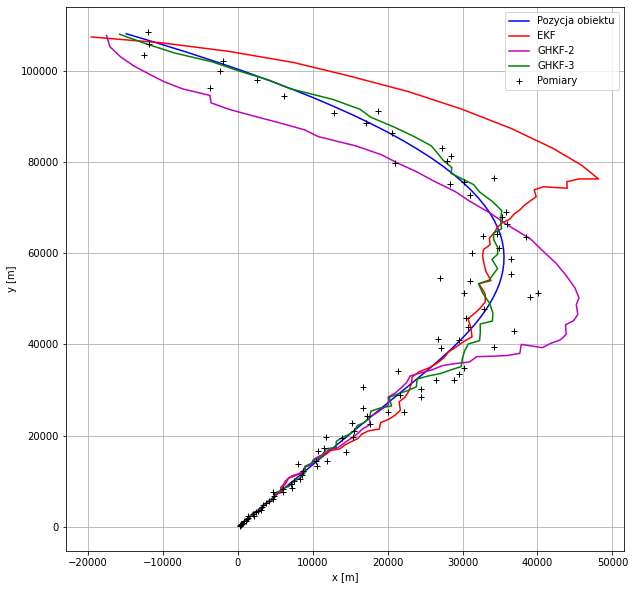

In [44]:
plt.figure(figsize=(10, 10))
plt.plot(pos_x, pos_y, 'b-')
plt.plot(ekf_x, ekf_y, 'r-')
plt.plot(ghkf2_x, ghkf2_y, 'm-')
plt.plot(ghkf3_x, ghkf3_y, 'g-')
# plt.plot(ghkf5_x, ghkf5_y, 'c-')
plt.plot(z_xs, z_ys, 'k+')
plt.legend(['Pozycja obiektu', 'EKF', 'GHKF-2', 'GHKF-3', 'Pomiary'])
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('2D_tracking_positions.jpg', bbox_inches='tight')
plt.show()

In [26]:
ekf_x_error = pos_x - ekf_x
ekf_y_error = pos_y - ekf_y
ekf_vx_error = vx - ekf_vx
ekf_vy_error = vy - ekf_vy
ekf_ax_error = ax - ekf_ax
ekf_ay_error = ay - ekf_ay
ghkf2_x_error = pos_x - ghkf2_x
ghkf2_y_error = pos_y - ghkf2_y
ghkf2_vx_error = vx - ghkf2_vx
ghkf2_vy_error = vy - ghkf2_vy
ghkf2_ax_error = ax - ghkf2_ax
ghkf2_ay_error = ay - ghkf2_ay
ghkf3_x_error = pos_x - ghkf3_x
ghkf3_y_error = pos_y - ghkf3_y
ghkf3_vx_error = vx - ghkf3_vx
ghkf3_vy_error = vy - ghkf3_vy
ghkf3_ax_error = ax - ghkf3_ax
ghkf3_ay_error = ay - ghkf3_ay
ghkf5_x_error = pos_x - ghkf5_x
ghkf5_y_error = pos_y - ghkf5_y
ghkf5_vx_error = vx - ghkf5_vx
ghkf5_vy_error = vy - ghkf5_vy
ghkf5_ax_error = ax - ghkf5_ax
ghkf5_ay_error = ay - ghkf5_ay

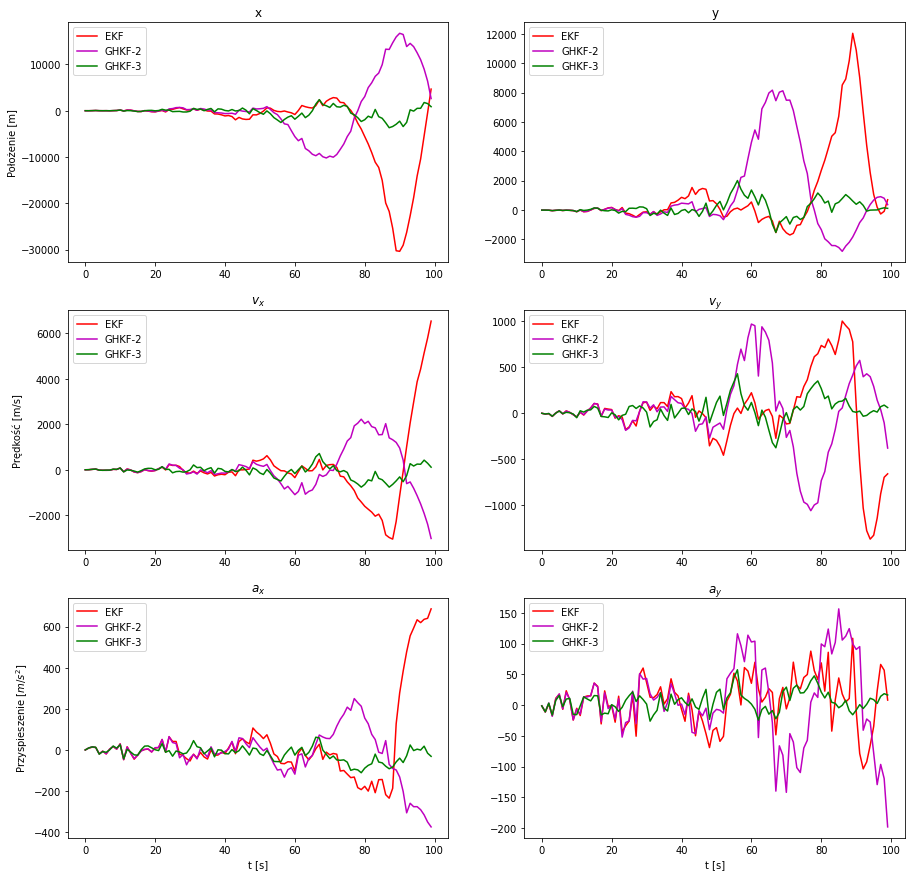

In [69]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(ekf_x_error, 'r-')
axs[0, 0].plot(ghkf2_x_error, 'm-')
axs[0, 0].plot(ghkf3_x_error, 'g-')
axs[0, 0].set(ylabel='Położenie [m]', title='x')
axs[0, 0].legend(['EKF', 'GHKF-2', 'GHKF-3'])


axs[0, 1].plot(ekf_y_error, 'r-')
axs[0, 1].plot(ghkf2_y_error, 'm-')
axs[0, 1].plot(ghkf3_y_error, 'g-')
axs[0, 1].set(title='y')
axs[0, 1].legend(['EKF', 'GHKF-2', 'GHKF-3'])

axs[1, 0].plot(ekf_vx_error, 'r-')
axs[1, 0].plot(ghkf2_vx_error, 'm-')
axs[1, 0].plot(ghkf3_vx_error, 'g-')
axs[1, 0].set(ylabel='Prędkość [m/s]', title=r'$v_x$')
axs[1, 0].legend(['EKF', 'GHKF-2', 'GHKF-3'])

axs[1, 1].plot(ekf_vy_error, 'r-')
axs[1, 1].plot(ghkf2_vy_error, 'm-')
axs[1, 1].plot(ghkf3_vy_error, 'g-')
axs[1, 1].set(title=r'$v_y$')
axs[1, 1].legend(['EKF', 'GHKF-2', 'GHKF-3'])

axs[2, 0].plot(ekf_ax_error, 'r-')
axs[2, 0].plot(ghkf2_ax_error, 'm-')
axs[2, 0].plot(ghkf3_ax_error, 'g-')
axs[2, 0].set(ylabel=r'Przyspieszenie $[m/s^2]$', title=r'$a_x$', xlabel='t [s]')
axs[2, 0].legend(['EKF', 'GHKF-2', 'GHKF-3'])

axs[2, 1].plot(ekf_ay_error, 'r-')
axs[2, 1].plot(ghkf2_ay_error, 'm-')
axs[2, 1].plot(ghkf3_ay_error, 'g-')
axs[2, 1].set(title=r'$a_y$', xlabel='t [s]')
axs[2, 1].legend(['EKF', 'GHKF-2', 'GHKF-3'])

# for ax in axs.flat:
#     ax.set(xlabel='t [s]')
# for ax in axs.flat:
#     ax.label_outer()
    
plt.savefig('2D_tracking_errors.jpg', bbox_inches='tight')
plt.show()

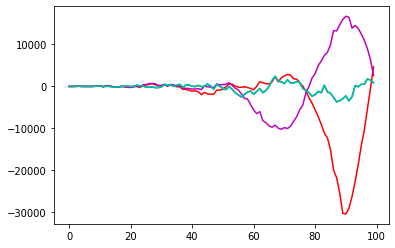

In [19]:
plt.plot(ekf_x_error, 'r-')
plt.plot(ghkf2_x_error, 'm-')
plt.plot(ghkf3_x_error, 'g-')
# plt.plot(ghkf5_x_error, 'c-')
plt.show()

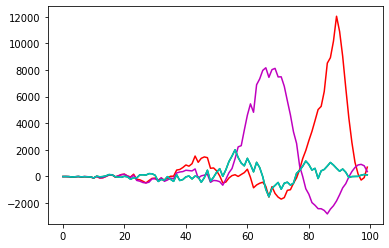

In [20]:
plt.plot(ekf_y_error, 'r-')
plt.plot(ghkf2_y_error, 'm-')
plt.plot(ghkf3_y_error, 'g-')
# plt.plot(ghkf5_y_error, 'c-')
plt.show()

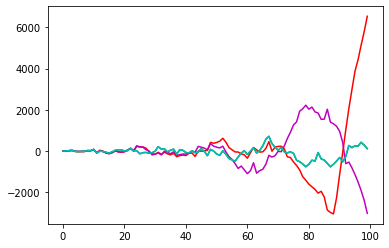

In [27]:
plt.plot(ekf_vx_error, 'r-')
plt.plot(ghkf2_vx_error, 'm-')
plt.plot(ghkf3_vx_error, 'g-')
# plt.plot(ghkf5_vx_error, 'c-')
plt.show()

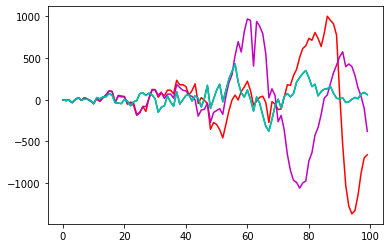

In [28]:
plt.plot(ekf_vy_error, 'r-')
plt.plot(ghkf2_vy_error, 'm-')
plt.plot(ghkf3_vy_error, 'g-')
# plt.plot(ghkf5_vy_error, 'c-')
plt.show()

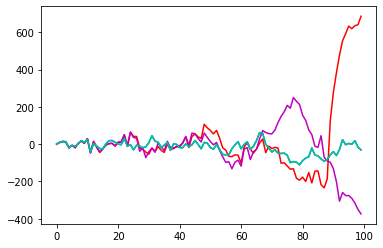

In [29]:
plt.plot(ekf_ax_error, 'r-')
plt.plot(ghkf2_ax_error, 'm-')
plt.plot(ghkf3_ax_error, 'g-')
# plt.plot(ghkf5_ax_error, 'c-')
plt.show()

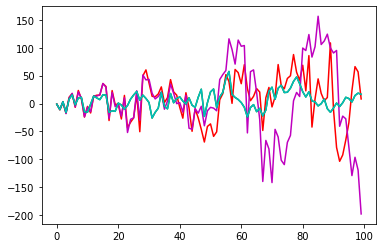

In [30]:
plt.plot(ekf_ay_error, 'r-')
plt.plot(ghkf2_ay_error, 'm-')
plt.plot(ghkf3_ay_error, 'g-')
# plt.plot(ghkf5_ay_error, 'c-')
plt.show()

Particular filters performance:

EKF:

In [45]:
numiterations = 100
times = []
for i in range(numiterations):
    ekf = EKF.ExtendedKalmanFilter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, F=F, H=H, dt=dt_filt)
    x = m
    x_noisy = x
    xs = []
    xs_ekf = []
    t_start = perf_counter()
    for k in range(nsteps):
        x = f_sim(x, u=0, k=k, dt=dt)
        u = 0
    #     x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=6, x_dim=6, dt=dt)
        x_noisy = x + multivariate_normal.rvs([0, 0, 0, 0, 0, 0], Q).reshape(6, 1)
        xs.append(x_noisy)
        ekf.predict(u)
        # measurement
        z, Pz = trueMeanAndCov(x_noisy, ekf.P, f=h, u=u, f_return_dim=2, x_dim=6, dt=dt, for_measurement=True)
    #         z = h(x) 
        z_noisy = z + multivariate_normal.rvs([0, 0], R).reshape(2, 1)
        ekf.update(z_noisy)
    t_stop = perf_counter()
    times.append(t_stop - t_start)
np.mean(times)

C:\Users\jaqbk\anaconda3\envs\ml_env\lib\site-packages\scipy\stats\_multivariate.py:666: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


0.2821801779999623

In [48]:
np.min(times)

0.2640308999998524

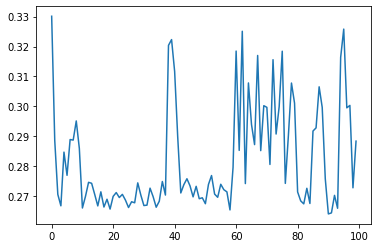

In [47]:
plt.plot(times)
plt.show()

GHKF-2

In [49]:
numiterations = 100
times = []
for i in range(numiterations):
    ghkf2 = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=2, dt=dt_filt)
    x = m
    x_noisy = x
    xs = []
    xs_ghkf2 = []
    t_start = perf_counter()
    for k in range(nsteps):
        x = f_sim(x, u=0, k=k, dt=dt)
        u = 0
    #     x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=6, x_dim=6, dt=dt)
        x_noisy = x + multivariate_normal.rvs([0, 0, 0, 0, 0, 0], Q).reshape(6, 1)
        xs.append(x_noisy)
        ghkf2.predict(u)
        # measurement
        z, Pz = trueMeanAndCov(x_noisy, ghkf2.P, f=h, u=u, f_return_dim=2, x_dim=6, dt=dt, for_measurement=True)
    #         z = h(x) 
        z_noisy = z + multivariate_normal.rvs([0, 0], R).reshape(2, 1)
        ghkf2.update(z_noisy)
    t_stop = perf_counter()
    times.append(t_stop - t_start)
np.mean(times)

0.6631589300000996

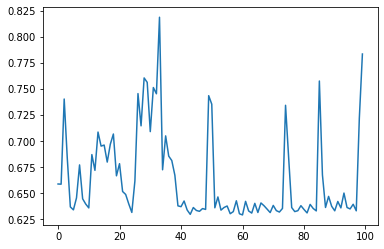

In [51]:
plt.plot(times)
plt.show()

In [50]:
np.min(times)

0.6290796000012051

In [52]:
numiterations = 100
times = []
for i in range(numiterations):
    ghkf3 = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=3, dt=dt_filt)
    x = m
    x_noisy = x
    xs = []
    xs_ghkf3 = []
    t_start = perf_counter()
    for k in range(nsteps):
        x = f_sim(x, u=0, k=k, dt=dt)
        u = 0
    #     x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=6, x_dim=6, dt=dt)
        x_noisy = x + multivariate_normal.rvs([0, 0, 0, 0, 0, 0], Q).reshape(6, 1)
        xs.append(x_noisy)
        ghkf3.predict(u)
        # measurement
        z, Pz = trueMeanAndCov(x_noisy, ghkf3.P, f=h, u=u, f_return_dim=2, x_dim=6, dt=dt, for_measurement=True)
    #         z = h(x) 
        z_noisy = z + multivariate_normal.rvs([0, 0], R).reshape(2, 1)
        ghkf3.update(z_noisy)
    t_stop = perf_counter()
    times.append(t_stop - t_start)
np.mean(times)

4.515732484999989

In [53]:
np.min(times)

4.3494479000000865

In [55]:
numiterations = 5
times = []
for i in range(numiterations):
    ghkf5 = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=5, dt=dt_filt)
    x = m
    x_noisy = x
    xs = []
    xs_ghkf5 = []
    t_start = perf_counter()
    for k in range(nsteps):
        x = f_sim(x, u=0, k=k, dt=dt)
        u = 0
    #     x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=6, x_dim=6, dt=dt)
        x_noisy = x + multivariate_normal.rvs([0, 0, 0, 0, 0, 0], Q).reshape(6, 1)
        xs.append(x_noisy)
        ghkf5.predict(u)
        # measurement
        z, Pz = trueMeanAndCov(x_noisy, ghkf5.P, f=h, u=u, f_return_dim=2, x_dim=6, dt=dt, for_measurement=True)
    #         z = h(x) 
        z_noisy = z + multivariate_normal.rvs([0, 0], R).reshape(2, 1)
        ghkf5.update(z_noisy)
    t_stop = perf_counter()
    times.append(t_stop - t_start)
np.mean(times)

92.4435361399992

In [56]:
np.min(times)

90.77351099999942

#### Sarka pendulum

In [85]:
dt = 0.001
qc = 1
Q = np.array([[qc*dt**3/3, qc*dt**2/2], [qc*dt**2/2, qc*dt]])
R = 0.32 * np.eye(1)
R_05 = scipy.linalg.sqrtm(R) 
m = np.array([1.5, 0]).reshape(2, 1)
P = np.eye(2)
nsteps = 5000
p = 4;
sqdt = np.sqrt(dt)
def f(x, u, dt=0.001):
    g = 9.81
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + dt * x2
    x2_next = x2 - g * np.sin(x1) * dt
    return np.array([x1_next, x2_next]).reshape(2, 1)
def h(x):
    x1 = x[0, 0]
    return np.array([np.sin(x1)]).reshape(1, 1)
def F(x, u, dt=0.001):
    g = 9.81
    x1 = x[0, 0]
    return np.array([[1, dt], [-g*np.cos(x1)*dt, 1]])
def H(x):
    x1 = x[0, 0]
    return np.array([np.cos(x1), 0]).reshape(1, 2)

In [88]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p)

In [95]:
x = m
xs = []
xs_noisy = []
xs_ekf = []
zs = []
xs_ekf = []
xs_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    ghkf.predict(u)
    x = f(x, u=0)
    xs.append(x)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    xs_noisy.append(x_noisy)
    # measurement
    z = h(x) + multivariate_normal.rvs([0], R)
    ekf.update(z)
    ghkf.update(z)
    xs_ekf.append(ekf.m)
    xs_ghkf.append(ghkf.m)
    zs.append(z)
    ts.append(k*dt)

In [96]:
angle_ekf = list(map(lambda x: x[0, 0], xs_ekf))
angle_ghkf = list(map(lambda x: x[0, 0], xs_ghkf))
angle_true = list(map(lambda x: x[0, 0], xs))
measurements = list(map(lambda x: x[0, 0], zs))

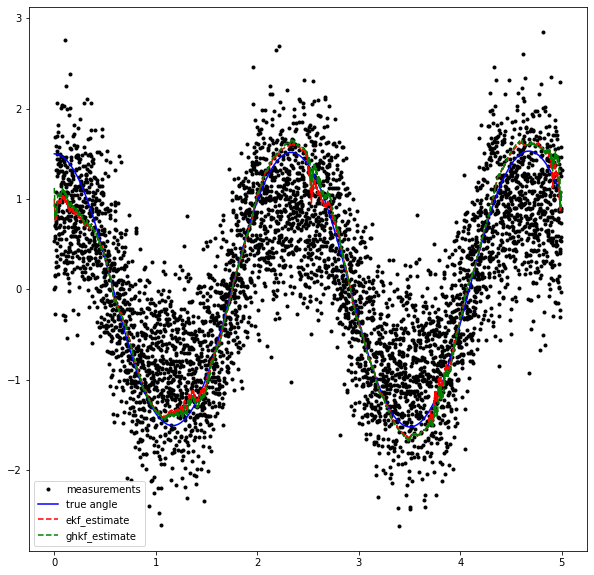

In [101]:
plt.figure(figsize=(10, 10))
plt.plot(ts, measurements, 'k.')
plt.plot(ts, angle_true, 'b-')
plt.plot(ts, angle_ekf, 'r--')
plt.plot(ts, angle_ghkf, 'g--')
plt.legend(['measurements', 'true angle', 'ekf_estimate', 'ghkf_estimate'])
plt.show()

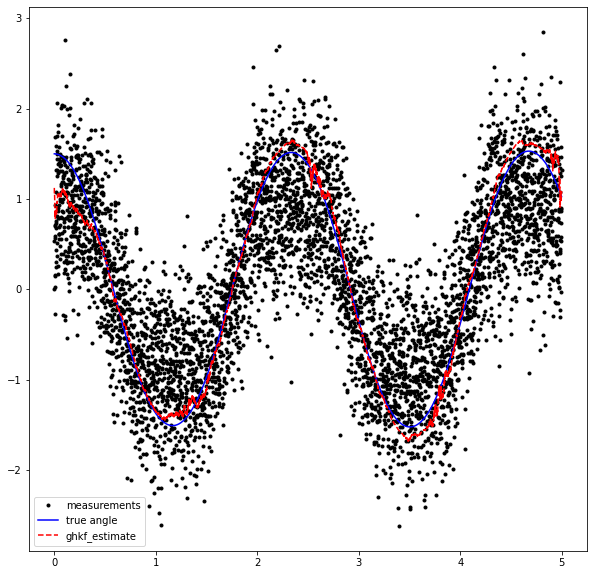

In [98]:
plt.figure(figsize=(10, 10))
plt.plot(ts, measurements, 'k.')
plt.plot(ts, angle_true, 'b-')
plt.plot(ts, angle_ghkf, 'r--')
plt.legend(['measurements', 'true angle', 'ghkf_estimate'])
plt.show()

In [99]:
rmse_ekf = np.sqrt(np.sum((np.array(angle_ekf) - np.array(angle_true))**2 / nsteps))
rmse_ekf

0.14575028710911705

In [100]:
rmse_ghkf = np.sqrt(np.sum((np.array(angle_ghkf) - np.array(angle_true))**2 / nsteps))
rmse_ghkf

0.14158128734250128

#### BOT (Bearing Only Tracking)

In [70]:
x1, x2, x_dash_pk, y_dash_pk = sympy.symbols('x_1, x_2, x_d, y_d')
H = sympy.Matrix([sympy.atan(y_dash_pk / (x1 - x_dash_pk))])
state = sympy.Matrix([x1, x2])
J = H.jacobian(state)
display(state)
display(H)
display(J)

Matrix([
[x_1],
[x_2]])

Matrix([[atan(y_d/(x_1 - x_d))]])

Matrix([[-y_d/((x_1 - x_d)**2*(y_d**2/(x_1 - x_d)**2 + 1)), 0]])

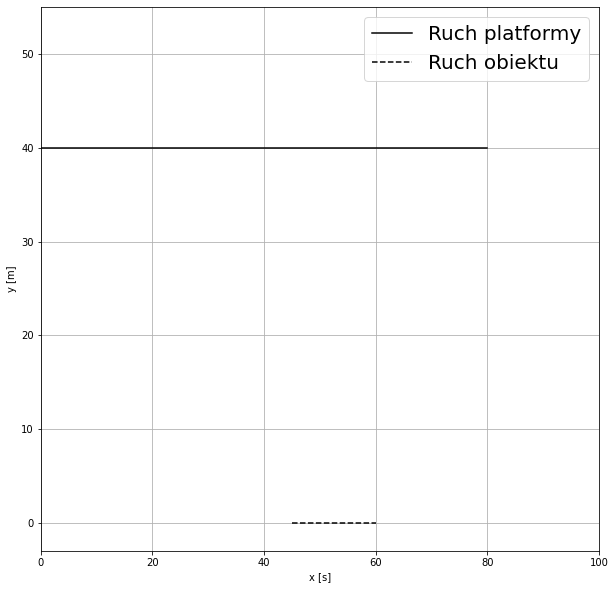

In [111]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.set_xlim([0, 100])
ax.set_ylim([-3, 55])
ax.set_xlabel('x [s]')
ax.set_ylabel('y [m]')
ax.grid()
ax.plot(np.linspace(0, 80, 2), [40, 40], 'k-')
ax.plot(np.linspace(45, 60, 2), [0, 0], 'k--')
# ax.arrow(20, 10, 30, 20)
ax.legend(['Ruch platformy', 'Ruch obiektu'], prop={'size': 20})
plt.savefig('BOT_axes.jpg', bbox_inches='tight')
plt.show()

In [172]:
nsteps = 50
dt = 0.01
m = np.array([45, 30]).reshape(2, 1)
P = np.eye(2)
# q = 10000
# Q = q * np.array([[dt**4/4, dt**3/2],
#                   [dt**3/2, dt**2]])
Q = 0.1 * np.eye(2)
R = 0.1 * np.eye(1)
r_x = 1
r_y = 1
y_dash_pk = 40
x_dash_pk = 50
# r_s = 0.052**2 # 3 deg squared
r_s = 0.105**2 # 6 deg squared
# r_s = 1**2 #
kwargs = { 'y_dash_pk': y_dash_pk, 'x_dash_pk': x_dash_pk }

In [173]:
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + dt * x2
    x2_next = x2
    return np.array([x1_next, x2_next]).reshape(2, 1)
def h(x, **kwargs):
    x1 = x[0, 0]
    y_pk = kwargs['y_pk']
    x_pk = kwargs['x_pk']
    return np.array([np.arctan(y_pk / (x1 - x_pk))]).reshape(1, 1)
def F(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([[1, dt],
                     [0, 1]])
def H(x, **kwargs):
    x1 = x[0, 0]
    y_pk = kwargs['y_pk']
    x_pk = kwargs['x_pk']
    return np.array([-y_pk / ((x1 - x_pk)**2 * (y_pk**2 / (x1 - x_pk)**2 + 1)), 0]).reshape(1, 2)

r_s = 0.105**2: (EKF diverges, GHKF-3 OK)

In [174]:
np.random.seed(2022)
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=3, dt=dt, kwargs=kwargs)
x = m
x_noisy = x
xs = []
xs_estimated_1_ekf = []
xs_estimated_1_ghkf = []
ts = []
xs_dash_pk = []
for k in range(nsteps):
    x_dash_pk = 160 * k * dt
    x_pk = x_dash_pk + multivariate_normal.rvs(0, r_x)
    y_pk = y_dash_pk + multivariate_normal.rvs(0, r_y)
    kwargs = { 'y_pk': y_dash_pk, 'x_pk': x_dash_pk }
    xs_dash_pk.append(x_pk)
    ekf.kwargs = kwargs
    ghkf.kwargs = kwargs
    x1 = x[0, 0]
    R = np.array([(y_dash_pk**2 * r_x + (x1 - x_dash_pk)**2 * r_y) / ((x1 - x_dash_pk)**2 + y_dash_pk**2)**2 + r_s]).reshape(1, 1)
    ekf.R = R
    ghkf.R = R
    u = 0
#     x = f(x, u, dt)
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=2, x_dim=2, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    xs.append(x[0, 0])
    ekf.predict(u)
    ghkf.predict(u)
    z = h(x_noisy, **kwargs)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=0, f_return_dim=1, x_dim=2, dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
#         zs.append(z_noisy)
#     z_x_axis = y_dash_pk / np.tan(z_noisy[0, 0]) + x_dash_pk
#     zs_x_axis.append(z_x_axis)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs_estimated_1_ekf.append(ekf.m[0, 0])
    xs_estimated_1_ghkf.append(ghkf.m[0, 0])
    ts.append(k*dt)

In [175]:
ekf.R

array([[0.01154397]])

In [176]:
ekf.Q

array([[0.1, 0. ],
       [0. , 0.1]])

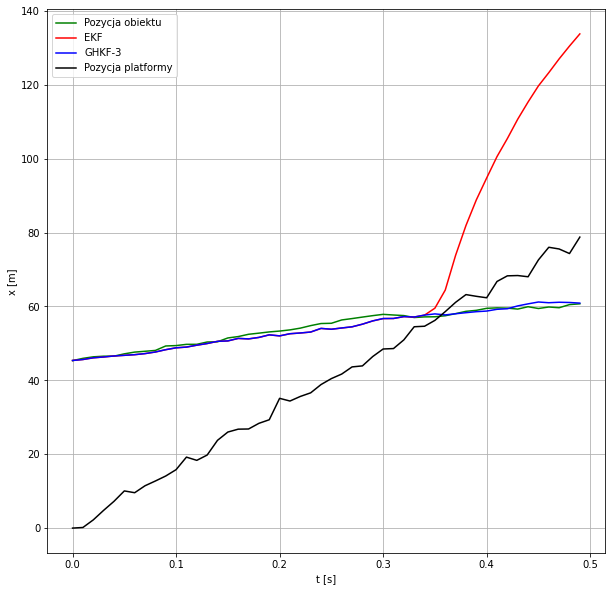

In [189]:
plt.figure(figsize=(10, 10))
plt.plot(ts, xs, 'g-')
plt.plot(ts, xs_estimated_1_ekf, 'r-')
plt.plot(ts, xs_estimated_1_ghkf, 'b-')
plt.plot(ts, xs_dash_pk, 'k-')
plt.legend(['Pozycja obiektu', 'EKF', 'GHKF-3', 'Pozycja platformy'])
plt.xlabel('t [s]')
plt.ylabel('x [m]')
plt.grid()
plt.savefig('BOT_results_1.jpg', bbox_inches='tight')
plt.show()

r_s = 1: (EKF OK, GHKF-3 OK)

In [178]:
r_s = 1**2

In [179]:
np.random.seed(2022)
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=3, dt=dt, kwargs=kwargs)
x = m
x_noisy = x
xs = []
xs_estimated_2_ekf = []
xs_estimated_2_ghkf = []
ts = []
xs_dash_pk = []
for k in range(nsteps):
    x_dash_pk = 160 * k * dt
    x_pk = x_dash_pk + multivariate_normal.rvs(0, r_x)
    y_pk = y_dash_pk + multivariate_normal.rvs(0, r_y)
    kwargs = { 'y_pk': y_dash_pk, 'x_pk': x_dash_pk }
    xs_dash_pk.append(x_pk)
    ekf.kwargs = kwargs
    ghkf.kwargs = kwargs
    x1 = x[0, 0]
    R = np.array([(y_dash_pk**2 * r_x + (x1 - x_dash_pk)**2 * r_y) / ((x1 - x_dash_pk)**2 + y_dash_pk**2)**2 + r_s]).reshape(1, 1)
    ekf.R = R
    ghkf.R = R
    u = 0
#     x = f(x, u, dt)
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=2, x_dim=2, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    xs.append(x[0, 0])
    ekf.predict(u)
    ghkf.predict(u)
    z = h(x_noisy, **kwargs)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=0, f_return_dim=1, x_dim=2, dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
#         zs.append(z_noisy)
#     z_x_axis = y_dash_pk / np.tan(z_noisy[0, 0]) + x_dash_pk
#     zs_x_axis.append(z_x_axis)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs_estimated_2_ekf.append(ekf.m[0, 0])
    xs_estimated_2_ghkf.append(ghkf.m[0, 0])
    ts.append(k*dt)

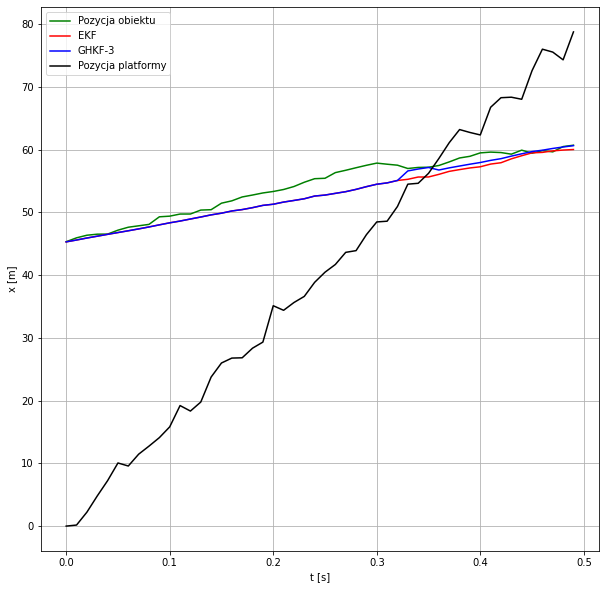

In [190]:
plt.figure(figsize=(10, 10))
plt.plot(ts, xs, 'g-')
plt.plot(ts, xs_estimated_2_ekf, 'r-')
plt.plot(ts, xs_estimated_2_ghkf, 'b-')
plt.plot(ts, xs_dash_pk, 'k-')
plt.legend(['Pozycja obiektu', 'EKF', 'GHKF-3', 'Pozycja platformy'])
plt.xlabel('t [s]')
plt.ylabel('x [m]')
plt.grid()
plt.savefig('BOT_results_2.jpg', bbox_inches='tight')
plt.show()

r_s = 0.052**2: (EKF diverges, GHKF-3 diverges, GHKF-5 OK)

In [182]:
r_s = 0.052**2

In [183]:
np.random.seed(2022)
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf3 = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=3, dt=dt, kwargs=kwargs)
ghkf5 = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=5, dt=dt, kwargs=kwargs)
x = m
x_noisy = x
xs = []
xs_estimated_3_ekf = []
xs_estimated_3_ghkf3 = []
xs_estimated_3_ghkf5 = []
ts = []
xs_dash_pk = []
for k in range(nsteps):
    x_dash_pk = 160 * k * dt
    x_pk = x_dash_pk + multivariate_normal.rvs(0, r_x)
    y_pk = y_dash_pk + multivariate_normal.rvs(0, r_y)
    kwargs = { 'y_pk': y_dash_pk, 'x_pk': x_dash_pk }
    xs_dash_pk.append(x_pk)
    ekf.kwargs = kwargs
    ghkf3.kwargs = kwargs
    ghkf5.kwargs = kwargs
    x1 = x[0, 0]
    R = np.array([(y_dash_pk**2 * r_x + (x1 - x_dash_pk)**2 * r_y) / ((x1 - x_dash_pk)**2 + y_dash_pk**2)**2 + r_s]).reshape(1, 1)
    ekf.R = R
    ghkf3.R = R
    ghkf5.R = R
    u = 0
#     x = f(x, u, dt)
    x, P_true = trueMeanAndCov(x_noisy, ghkf5.P, f, u=u, f_return_dim=2, x_dim=2, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    xs.append(x[0, 0])
    ekf.predict(u)
    ghkf3.predict(u)
    ghkf5.predict(u)
    z = h(x_noisy, **kwargs)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=0, f_return_dim=1, x_dim=2, dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
#         zs.append(z_noisy)
#     z_x_axis = y_dash_pk / np.tan(z_noisy[0, 0]) + x_dash_pk
#     zs_x_axis.append(z_x_axis)
    ekf.update(z_noisy)
    ghkf3.update(z_noisy)
    ghkf5.update(z_noisy)
    xs_estimated_3_ekf.append(ekf.m[0, 0])
    xs_estimated_3_ghkf3.append(ghkf3.m[0, 0])
    xs_estimated_3_ghkf5.append(ghkf5.m[0, 0])
    ts.append(k*dt)

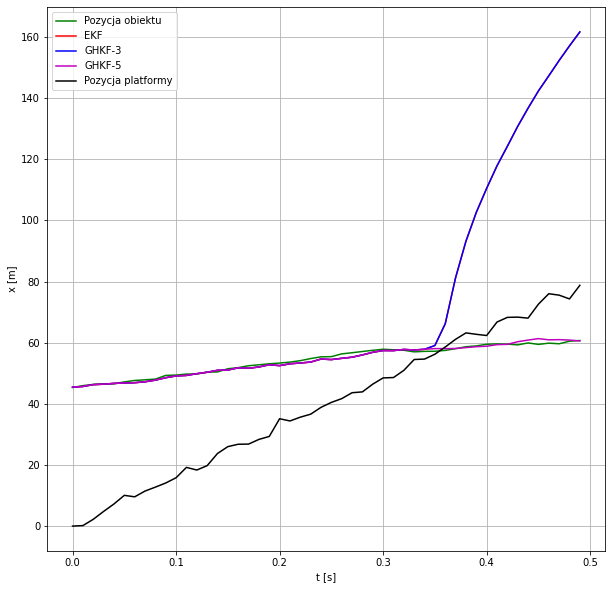

In [195]:
plt.figure(figsize=(10, 10))
plt.plot(ts, xs, 'g-')
plt.plot(ts, xs_estimated_3_ekf, 'r-')
plt.plot(ts, xs_estimated_3_ghkf3, 'b-')
plt.plot(ts, xs_estimated_3_ghkf5, '-', color='m')
plt.plot(ts, xs_dash_pk, 'k-')
plt.legend(['Pozycja obiektu', 'EKF', 'GHKF-3', 'GHKF-5', 'Pozycja platformy'])
plt.xlabel('t [s]')
plt.ylabel('x [m]')
plt.grid()
plt.savefig('BOT_results_3.jpg', bbox_inches='tight')
plt.show()